<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2021 - Homework 02</h1>

<h3 style="color:blue">2021-05-31</h3>

<h3 style="color:blue"> Authors: David Farré Gil, Blai Ras Jimenez, Irene Bonafonte Pardàs </h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

## Data Reading

In [1]:
data <- read.csv("aug_train.csv")
test <- read.csv("aug_test.csv")

In [2]:
test_response <- read.csv("Test_Response.csv")

In [3]:
test$Response <- test_response$Response

## Data Analysis

### Variables

01. `id`:        id of the subject.   
02. `Gender`:        Sex of the subject.
03. `Age`:         Age of the subject.
04. `Driving License`:      Whether if the subject has or not a driver's license.
05. `Region_Code`:          Coded region name.
06. `Previously_Insured`:      Whether if the subject has already a health insurance.
07. `Vehicle_Age`:  Number of years of the subject's car.
08. `Vehicle_Damage`:   Measure of detriment of the subject's car.
09. `Annual_Premium`:          Number of citations in total.
10. `Policy_Sales_Channel`:      Sum of money that the subject needs to pay regularly to an insurance company.
11. `Vintage`:     Days the subject is insured until now.
12. `Response`: Whether the subject said yes or no to getting a vehicle insurance.

As we can see, we will get rid of the variables `id`, `Region_Code` and `Policy_Sales_Channel` since they do not bring any substantial information towards the goal of predicting whether a customer would be interested in Vehicle Insurance. Even if they did, they should not be used towards that goal, it may even be a case of spurious correlation.

In [4]:
columns <- c("Gender","Age","Driving_License","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Vintage","Response")
data <- data[,columns]
test <- test[,columns]

In [5]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : chr  "Male" "Male" "Female" "Female" ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : chr  "< 1 Year" "1-2 Year" "1-2 Year" "< 1 Year" ...
 $ Vehicle_Damage    : chr  "No" "Yes" "Yes" "No" ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


As we can see, there's a few categorical columns. For the sake of the model creation and training, we will convert them to numerical, e.g. ``Female`` is coded to ``0`` and ``Male`` is coded to  ``1``, using the ``preprocess`` function below. We can convert ``Vehilce_Age`` to numerical in a similar manner, because it is a discrete variable (the levels have an order) and, therefore, there is no need of doing one-hot encodings.

In [6]:
preprocess <- function(data) {
    data$Vehicle_Age <- as.numeric(factor(data$Vehicle_Age, levels=c('< 1 Year','1-2 Year','> 2 Years')))
    data$Vehicle_Damage <- as.numeric(factor(data$Vehicle_Damage, levels=c('No','Yes'))) 
    data$Gender <- as.numeric(factor(data$Gender))
    
    # We substract 1 to have variables with value 0 and 1 (instead of 1 and 2)
    columns <- c('Vehicle_Age','Vehicle_Damage','Gender')    
    data[,columns] <- apply(data[,columns], MARGIN=2, function(x) x-1)
    return(data)
}

In [7]:
data <- preprocess(data)
test <- preprocess(test)

In [8]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : num  1 1 0 0 1 0 1 1 0 1 ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : num  0 1 1 0 0 0 1 1 1 1 ...
 $ Vehicle_Damage    : num  0 1 1 0 0 0 1 0 1 1 ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


In [9]:
Num.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) > 3))
Bin.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) <= 3))

Let's check the distribution of each variable in the data set. We can see a strong unbalance for many of the variables, including Response (which is the most concerning one, as it is the variable we want to predict), vehicle age and driving license.

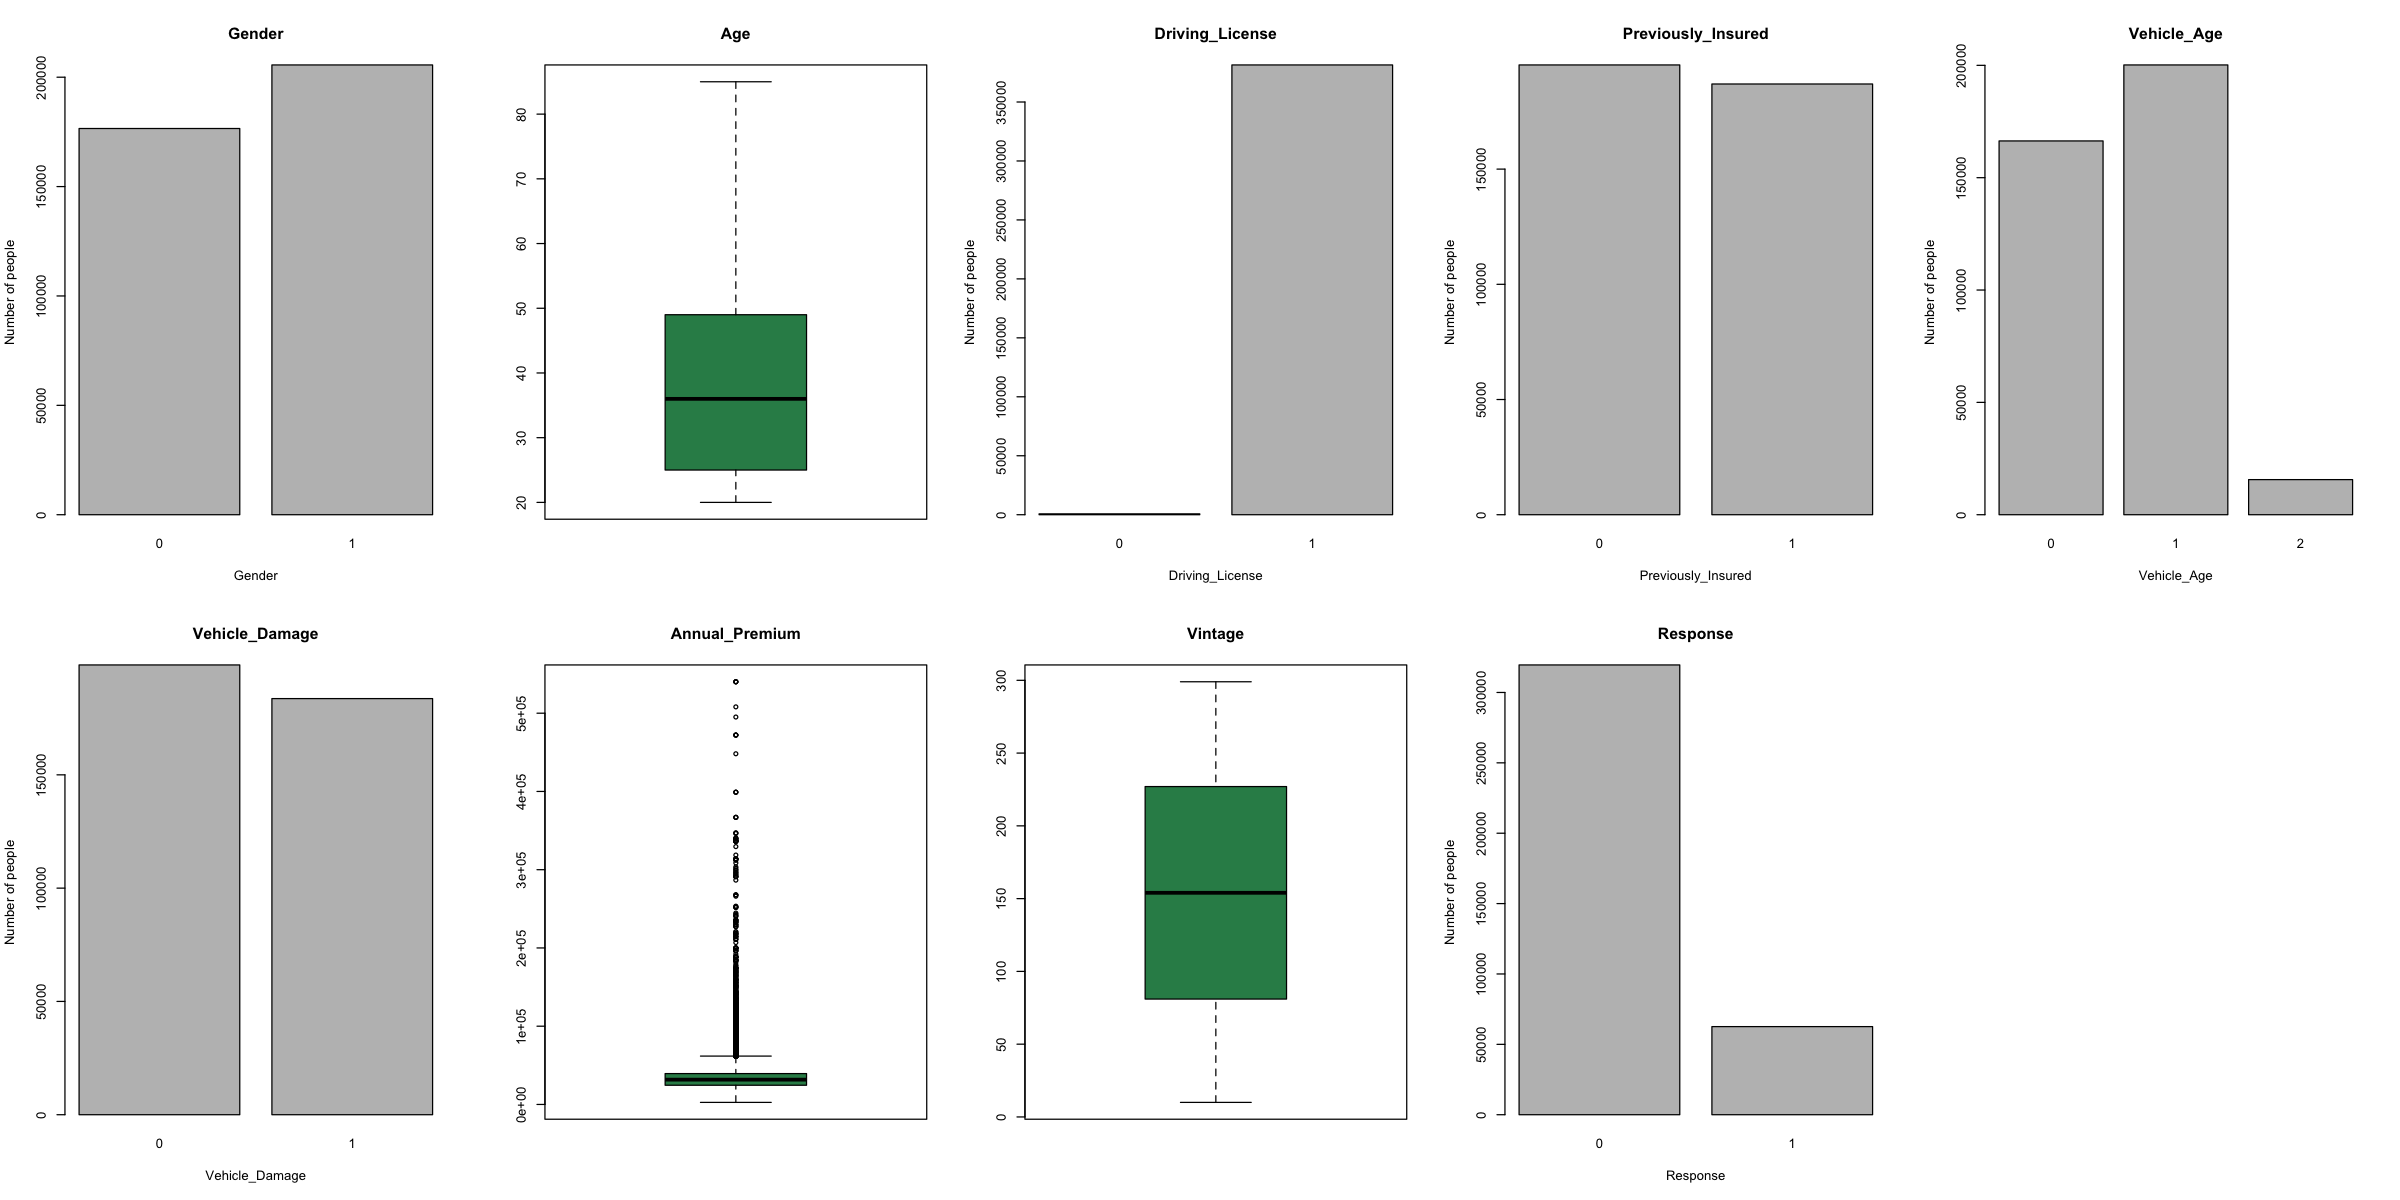

In [10]:
options(repr.plot.width=20,repr.plot.height=10)
par(mfrow=c(2,5))
for (i in 1:ncol(data)) {
    if (i %in% Num.vars){
        boxplot(data[,i],col="seagreen",main=colnames(data)[i])
    } else {
        barplot(table(data[,i]), ylab="Number of people", xlab=colnames(data)[i], main=colnames(data)[i])
    }
}

And now, the possible correlation that might occurr betwen this variables. We only study this among the numerical variables (those with more than 3 unique levels), excluding categorical variables. As manny of our variables are categorical, this analysis is not very insightful. Let's plot this correlation just in case:



In [11]:
round(cor(data[,Num.vars]),2)

Age  Annual_Premium Vintage
Age            1.00 0.07           0      
Annual_Premium 0.07 1.00           0      
Vintage        0.00 0.00           1

In [12]:
#Lasts 1 min 48 secs
#options(repr.plot.width=10,repr.plot.height=10)
#pairs(data[,Num.vars],col="seagreen")

Do we have to deal with null values in the dataset? No.

In [13]:
sum(is.na(data))
sum(is.na(test))

[1] 0

[1] 0

A common practice in Machine Learning is perform feature scaling, which helps most models to converge more quickly towards the minima. We can achieve this with the function ``scale``, which centers the variable to 0 mean and unit variance. We will scale all the numerical variables, except for the target variable (``Response``).

In [14]:
data[,Num.vars] <-  as.data.frame(scale(data[,Num.vars]))
test[,Num.vars] <-  as.data.frame(scale(test[,Num.vars]))
data[1:5,]

Gender Age        Driving_License Previously_Insured Vehicle_Age
1 1      -1.0866095 1               1                  0          
2 1       0.2268557 1               0                  1          
3 0       1.8030141 1               0                  1          
4 0      -1.0866095 1               0                  0          
5 1      -0.6925699 1               1                  0          
  Vehicle_Damage Annual_Premium Vintage    Response
1 0              -1.64587604    -1.6503165 0       
2 1               0.73942256    -0.2291683 0       
3 1               0.30065937     1.1800376 0       
4 0              -0.17971774    -1.0173681 0       
5 0              -0.09895155     0.6784558 0

Let's look at this class imbalance we've been told:

In [15]:
print("Cases:")
table(data$Response)
print("Proportion:")
round(table(data$Response)/nrow(data)*100,2)

[1] "Cases:"



     0      1 
319553  62601 

[1] "Proportion:"



    0     1 
83.62 16.38 

Huge! Our first approach to deal with this problem is resampling with the function ``resample`` that we have below. It takes as parameter the amount of samples we want from each class and returns the filtered dataframe. With this approach, we balance the dataset, because we get the same number of samples from the positive than from the negative class.

We have selected this simple approach, and not more sofisticated methods such as SMOTE for the following reason: SMOTE deals with the class imbalance by oversampling the minority class, doing data augmentation in a very smart manner. However, in our case, we have more samples than those we can process, and we need to reduce the training dataset. For this reason, we think that it is sufficient in our case to do undersampling. When undersampling, we can select the same numbers of samples from both classes and, so, the class imbalance is solved. 

In [16]:
resample <- function(data,size) {
    total = size * 2
    if (total > nrow(data)) {
        cat("Not enough data to create a dataframe of size ",total)
        return(data)
    } else if (size > 62601) {
        print("Not enough samples!")
        return(data)
    }
    negative <- sample(x=which(data$Response == 0), size=size, replace=FALSE)
    positive <- sample(x=which(data$Response == 1), size=size, replace=FALSE)
    resampled_idx <- c(negative, positive)
    return(data[resampled_idx, ])
}

## Modeling

Below we study the problem using different tools. We've decided to use rstanarm, rstan. JAGS and MCMCpack.

### Frequentist approach

We will start fitting a logistic regression with the frequentist approach. We will do this in order to get a prior for the intercept and also to get a first idea on the minimum number of samples we need to solve the problem in a estable manner. This first model will also be useful to compare the results we obtain with the Bayesian approaches.

In [17]:
# Repeat 4 times to compare results
for (i in 1:4){
    
    # Select samples
    max_size <- min(table(data$Response))
    n <- max_size*0.02
    df <- resample(data,n)
    if (i == 1){
        print('Matrix dimensions: ')
        print(dim(df))
        print('Number of positive and negative cases: ')
        print(table(df$Response))
    }

    # Fit logistic regression
    formula <- as.formula(paste0('Response ~ ',paste(colnames(df)[-ncol(df)],collapse=' + ')))
    lm.m <- glm(formula, data = df, family = "binomial")
    
    # Summary of the model
    print(summary(lm.m))
}

[1] "Matrix dimensions: "
[1] 2504    9
[1] "Number of positive and negative cases: "

   0    1 
1252 1252 

Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.24730  -0.04660   0.09454   0.74585   2.83887  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.57611    1.27183  -2.812  0.00493 ** 
Gender             -0.01950    0.11520  -0.169  0.86557    
Age                -0.43334    0.09017  -4.806 1.54e-06 ***
Driving_License     1.19159    1.24007   0.961  0.33660    
Previously_Insured -5.23256    1.01773  -5.141 2.73e-07 ***
Vehicle_Age         0.92453    0.15667   5.901 3.61e-09 ***
Vehicle_Damage      2.75498    0.30139   9.141  < 2e-16 ***
Annual_Premium      0.10376    0.05324   1.949  0.05129 .  
Vintage             0.03433    0.05601   0.613  0.53992    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter 

By manually inspecting the results, we can see that they are quite inestable. The significance of each variable changes strongly based on the selected samples. For instance, gender was quite significant at the second iteration, with a 0.304 estimate for the change of odds, but unsignificant in the other sample sets, with estimates as low as 0.04. We have tried again by increasing progressively the sample sizes (results not shown) and show here the results for the smallest sample size we were satisfied with.

In [18]:
# Repeat 4 times to compare results
for (i in 1:4){
    
    # Select samples
    max_size <- min(table(data$Response))
    n <- max_size*0.2
    df <- resample(data,n)
    if (i == 1){
        print('Matrix dimensions: ')
        print(dim(df))
        print('Number of positive and negative cases: ')
        print(table(df$Response))
    }

    # Fit logistic regression
    formula <- as.formula(paste0('Response ~ ',paste(colnames(df)[-ncol(df)],collapse=' + ')))
    lm.m <- glm(formula, data = df, family = "binomial")
    
    # Summary of the model
    print(summary(lm.m))
}

[1] "Matrix dimensions: "
[1] 25040     9
[1] "Number of positive and negative cases: "

    0     1 
12520 12520 

Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4960  -0.0893   0.1379   0.7476   3.5705  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -4.71149    0.47959  -9.824  < 2e-16 ***
Gender              0.22071    0.03556   6.206 5.43e-10 ***
Age                -0.44437    0.02752 -16.149  < 2e-16 ***
Driving_License     2.10495    0.46943   4.484 7.32e-06 ***
Previously_Insured -4.11555    0.19596 -21.002  < 2e-16 ***
Vehicle_Age         1.19223    0.04830  24.682  < 2e-16 ***
Vehicle_Damage      2.56534    0.09456  27.128  < 2e-16 ***
Annual_Premium      0.05239    0.01684   3.112  0.00186 ** 
Vintage            -0.01810    0.01750  -1.034  0.30109    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for 

The results seem to be quite stable now, both in terms of estimates and p-values. Therefore (if feasible), we will keep using 20% of the samples in the experiments below. Because the computations may take too long, we have decided to first explore the models using small sample sizes, but finally execute all the models using 20% of the samples.

We will keep the intercept from the linear regression (b0 coeficient) to use it to center the intercept Bayesian prior.

In [19]:
b0_hat = as.numeric(coef(lm.m)[1])
round(b0_hat,4)

[1] -3.7278

### Random Forest

For comparison, we will fit a frequentist random forest, that we have been told that works quite well, and check its performance. This will give us some reference on how well can we expect our bayesian models to perform. To be fair with the Bayesian methods, in this case we will also use only 20% of the training samples.

This model also gives us some additional intuition into which variables are more important, which will be usefull to know.

In [20]:
library(randomForest)
n <- max_size*0.2
df <- resample(data,n)

# Take some samples for testing (all samples with the same probability)
n_test <- 1000
samples_test <- sample(1:nrow(test), size=n_test)
df_test = test[samples_test,-ncol(test)]
y_test = factor(test[samples_test,'Response'])

rf.model <- randomForest(x=df[,-ncol(df)], y=factor(df$Response), 
                         importance = TRUE, ntree=500) 

rf.model
varImpPlot(rf.model,type=2)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



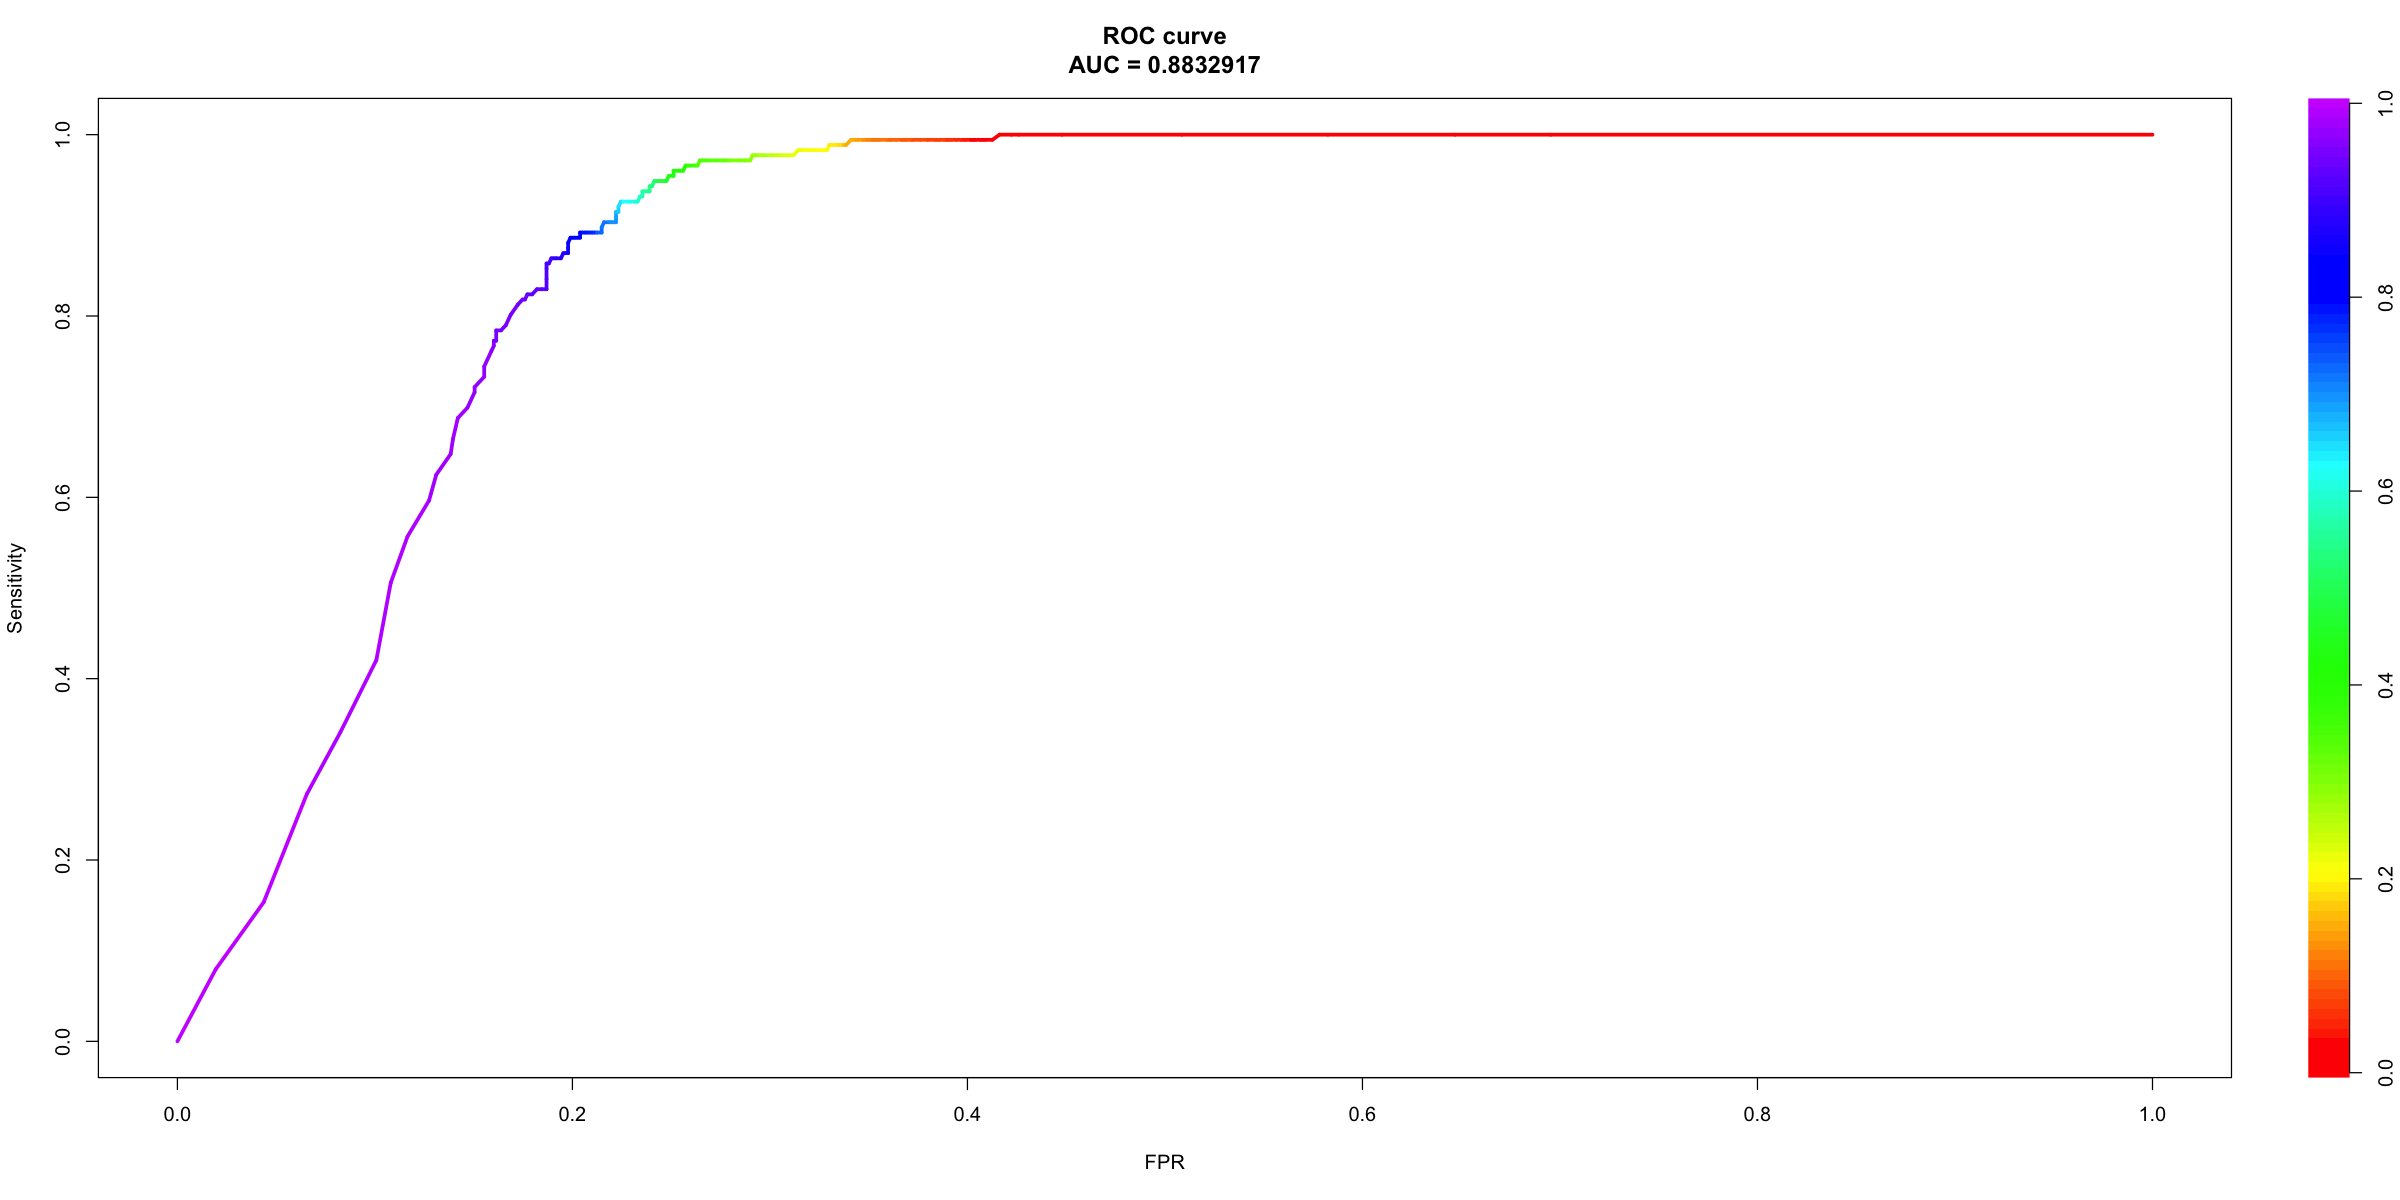

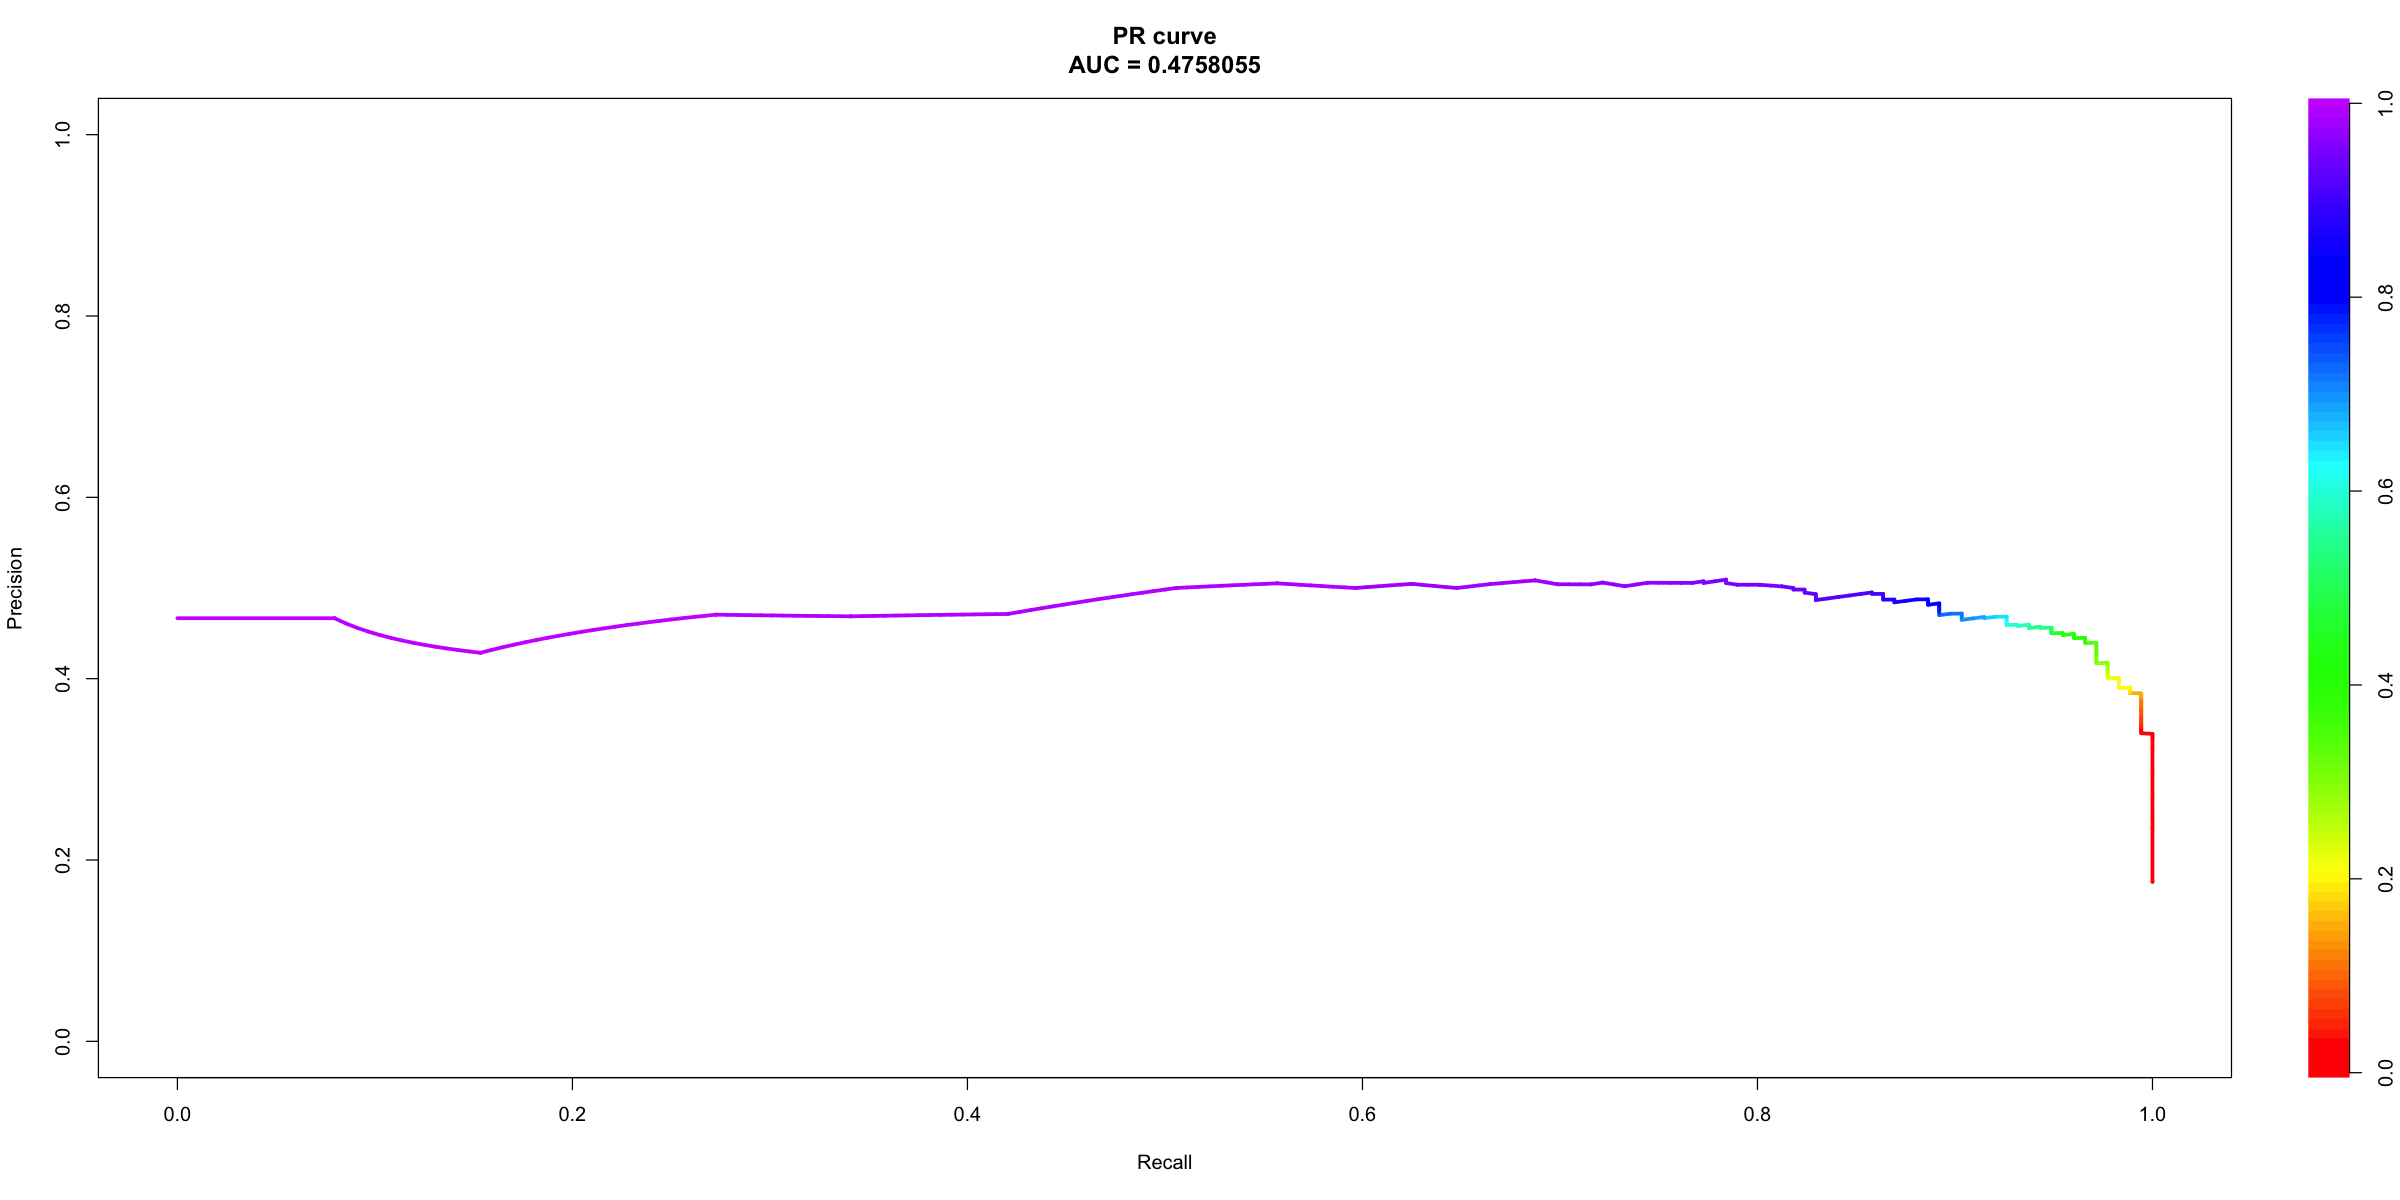

In [41]:
library(PRROC)

# Reconvert y_test to numeric
y_test <- as.numeric(as.character(y_test))

# Predict test samples
rf.ytest.preds <- predict(rf.model, df_test, type="prob")[,2]

# Check performance with ROC and Precision and Recall curbes
rf.roc <- roc.curve(weights.class0=y_test, scores.class0=rf.ytest.preds, curve=TRUE)
plot(rf.roc)
rf.pr <- pr.curve(weights.class0=y_test, scores.class0=rf.ytest.preds, curve=TRUE)
plot(rf.pr)

We observe what seems to be a very good performance in terms of the AUC-ROC, with a value of 0,883. It should be noted that this is in fact not such a good performance, because we have an 80% majority class. This means, that assigning every one to the majority class already gives an acuracy of 80%. It is for this reason that the PR-AUC, which is less sensible to the imbalance, is much worse, with a value of 0,476. 

Regarding the features, we see that vehicle damage and being insured are the most predictive features. This is coherent with the estimates and p-values observed in the linear model.

### RStan

#### Defining and fitting the model

For this first model, we will use all the predictor variables and propose the following model:

$$
    y_i \sim \operatorname{Bernoulli}(\pi_i)
$$

Where the inverse link function:

$$
    \pi_i = \dfrac{\exp(x_i'\cdot\beta)}{1 + \exp(x_i'\cdot \beta)}
$$

And a multivariate Normal prior on $\beta$:

$$
    \beta \sim \operatorname{N}(b_0,B_0^{-1})
$$

For all the coefficients we have started using a standard deviation of the prioir of 3. After increasing the values to 10, we have observed a better performance, so we have kept these SD. For the intercept, $\beta_{0}$, the normal is centered in the estimate of the frequentist linear model, $\hat{\beta_{0}}$. All the other coefficients are centered on 0.

We have used the `generate_samples` section of the code to compute posterior probability distributions for the response variable of the test dataset, that we will afterwards use to check the model performance.

In [21]:
#install.packages("rstan", repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [22]:
# Subsample dataset
max_size <- min(table(data$Response))
n <- max_size*0.01
#n <- max_size*0.2
df <- resample(data,n)
n <- nrow(df) # Number of samples
p <- ncol(df) - 1 # Number of predictors (we also have response in df)
print(n)
print(p)

# Take some samples for testing (all samples with the same probability, i.e. no balancing)
n_test <- 300
samples_test <- sample(1:nrow(test), size=n_test)
df_test = test[samples_test,-ncol(test)]
y_test = test[samples_test,'Response']

[1] 1252
[1] 8


In [26]:
# Define the model
logit.stan.model <- "
    data{
        int<lower=1> n; //Number of data items
        int<lower=1> p; //Number of coefficients
        matrix[n,p] X; //Predictors matrix
        int<lower=0,upper=1> y[n]; //Outcome vector
        real b0_hat;
        int<lower = 1> n_test;
        matrix[n_test,p] x_test; //Predictors matrix for test

    }
    parameters{
        real b0;
        vector[p] b;
    }
    model{
        // Model
        y ~ bernoulli_logit(b0 + X*b);

        // Priors
        b0 ~ normal(b0_hat,10);

        for(i in 1:p)
            b[i] ~ normal(0,10);

    }

    generated quantities {
        vector[n_test] y_test;
        y_test=inv_logit(b0 + x_test*b);
    //y_test = bernoulli_rng(inv_logit(b0 + x_test*b));
       // for (i in 1:n_test)
       //     y_test[n]=bernoulli_rng(inv_logit(b0 + x_test[i,:]*b));
    }   
"

In [27]:
# Add the data
logit.stan.data <- list(n=n, p=p, y=df$Response, X=as.matrix(df[,-ncol(df)]), b0_hat=b0_hat,
                       x_test=as.matrix(df_test), n_test=n_test)

In [28]:
# Run
logit.stan <- stan(model_code = logit.stan.model, data = logit.stan.data, iter = 2500,
             chains = 3, verbose = FALSE, seed=101, warmup=500)

Warning message:
“There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [68]:
# Store parameters and predictions distribution
logit.stan.summary <- summary(logit.stan)$summary
logit.stan.preds <- logit.stan.summary[grepl('y', row.names(logit.stan.summary)), ]
logit.stan.summary <- logit.stan.summary[grepl('b', row.names(logit.stan.summary)), ]

#### Diagnostic plots

With the trace plots, we see a good convergence and no auto-correlation. Therefore, we can keep using the current number of iterations and warmup.

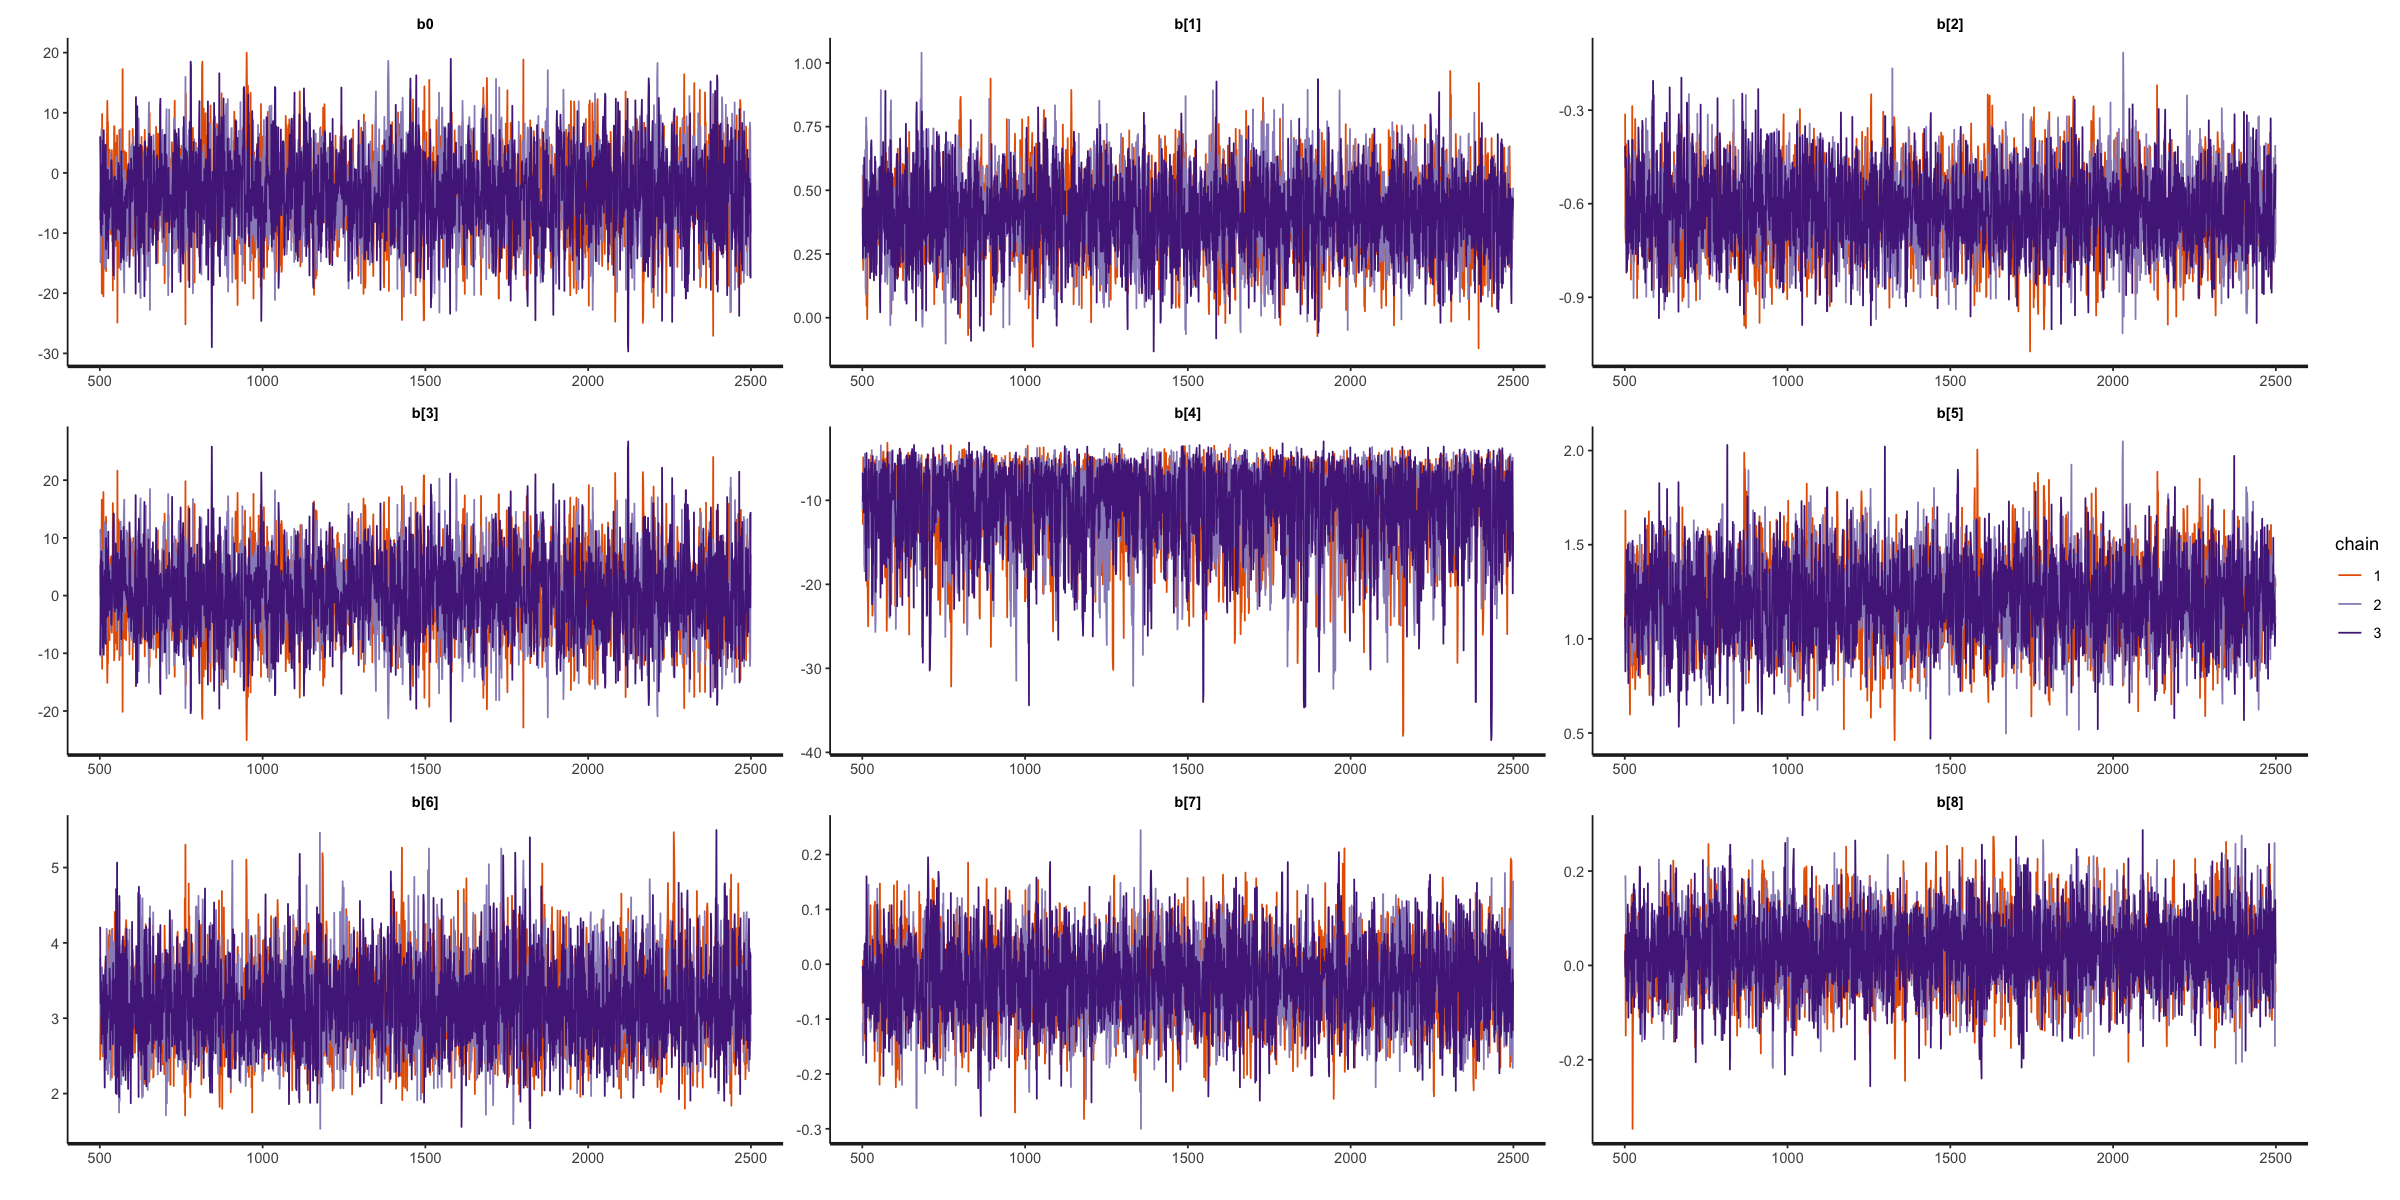

In [69]:
# Trace plots
require(bayesplot)
options(repr.plot.width=20, repr.plot.height=10)
stan_trace(logit.stan, pars=c("b0","b"))

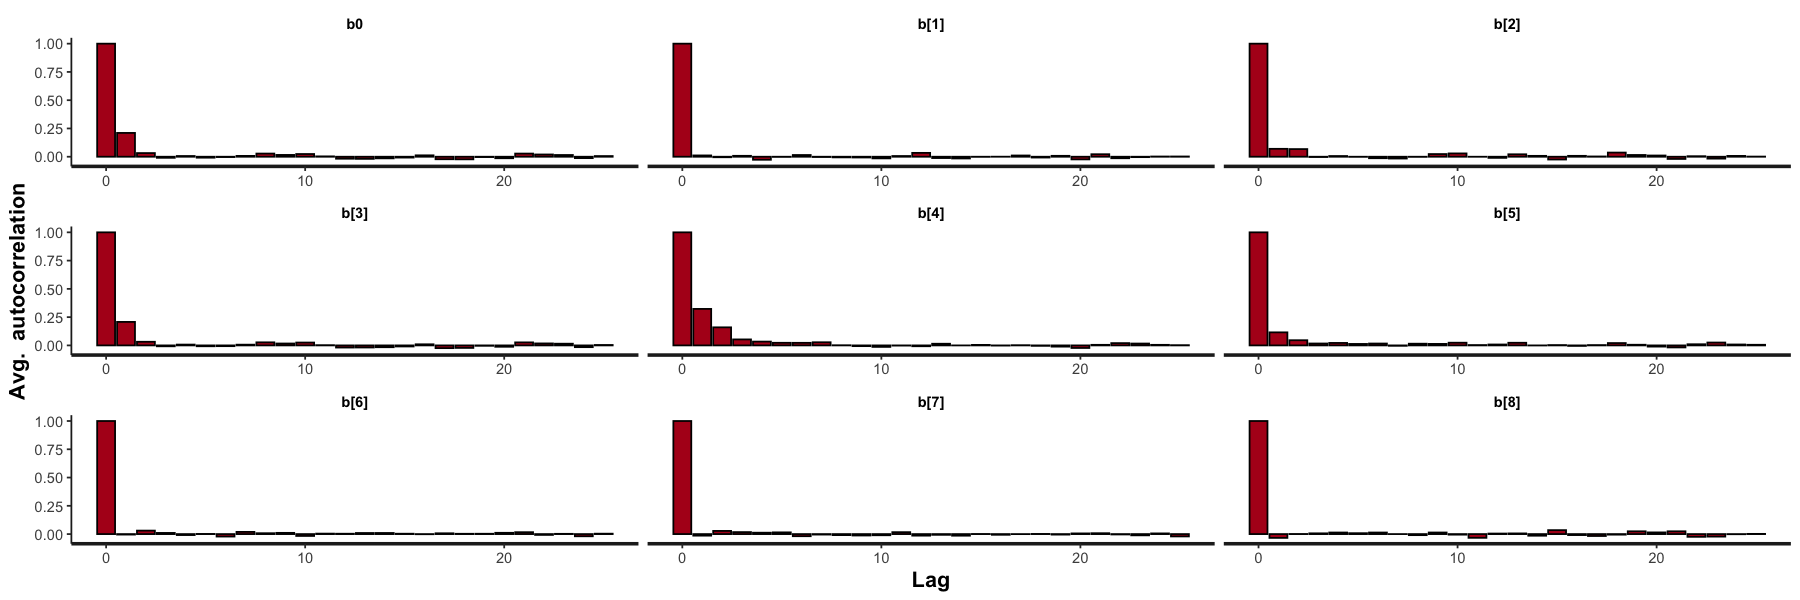

In [70]:
# Auto-correlation
options(repr.plot.width=15, repr.plot.height=5)
stan_ac(logit.stan, pars=c("b0","b"))

#### Coefficients posterior distribution

Let's investigate the obtained posterior distributions for the coefficients. By comparing the mean of the coefficients to the estimates of the frequentist linear model, we can see that the estimations are, in fact, quite concordant, specially for the coefficients that were significant in the linear model.

In [71]:
# Print parameters summary distribution (mean, median)
logit.stan.summary

# Compare to the paramaters from the frequentist linear model
summary(lm.m)

mean         se_mean     sd         2.5%         25%          50%         
b0    -3.53248390 0.109621259 7.00405313 -17.59193723  -8.15880999  -3.54043793
b[1]   0.39663742 0.002102628 0.16079585   0.07768559   0.28752858   0.39613156
b[2]  -0.62295156 0.001846241 0.12645198  -0.87320126  -0.70748621  -0.62339114
b[3]   0.26492431 0.109627787 7.00356459 -13.20916635  -4.40597946   0.31582353
b[4] -11.18675722 0.100522849 5.13115023 -23.55204199 -14.16713338 -10.08967989
b[5]   1.20515867 0.003554731 0.22147285   0.77719835   1.05448101   1.20576821
b[6]   3.20227826 0.007613440 0.57000123   2.17954235   2.80686621   3.17252626
b[7]  -0.03214621 0.001002262 0.07281119  -0.17139229  -0.08206360  -0.03151446
b[8]   0.03047062 0.001012512 0.07911353  -0.12303085  -0.02473869   0.03001380
     75%         97.5%      n_eff    Rhat     
b0    1.16937609  9.9195655 4082.341 1.0001878
b[1]  0.50285978  0.7098830 5848.232 0.9998523
b[2] -0.53667346 -0.3730017 4691.098 1.0005660
b[3]  4.92912219 14.2366619 4081.286 1.0001687
b[4] -7.27486188 -4.4487635 2605.553 1.0006563
b[5]  1.35121846  1.6435683 3881.751 1.0004864
b[6]  3.56141822  4.3811792 5605.182 0.9999472
b[7]  0.01477738  0.1109352 5277.562 1.0003034
b[8]  0.08357929  0.1878539 6105.220 1.0004773


Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4275  -0.0927   0.1692   0.7533   3.5903  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.940330   0.449913  -8.758  < 2e-16 ***
Gender              0.129192   0.035452   3.644 0.000268 ***
Age                -0.416915   0.027196 -15.330  < 2e-16 ***
Driving_License     1.658949   0.440187   3.769 0.000164 ***
Previously_Insured -4.249669   0.193085 -22.009  < 2e-16 ***
Vehicle_Age         1.140418   0.047730  23.893  < 2e-16 ***
Vehicle_Damage      2.321925   0.090821  25.566  < 2e-16 ***
Annual_Premium      0.042756   0.017034   2.510 0.012072 *  
Vintage            -0.007652   0.017447  -0.439 0.660974    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 34713  on 25039  degrees of freedom
Residual deviance:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



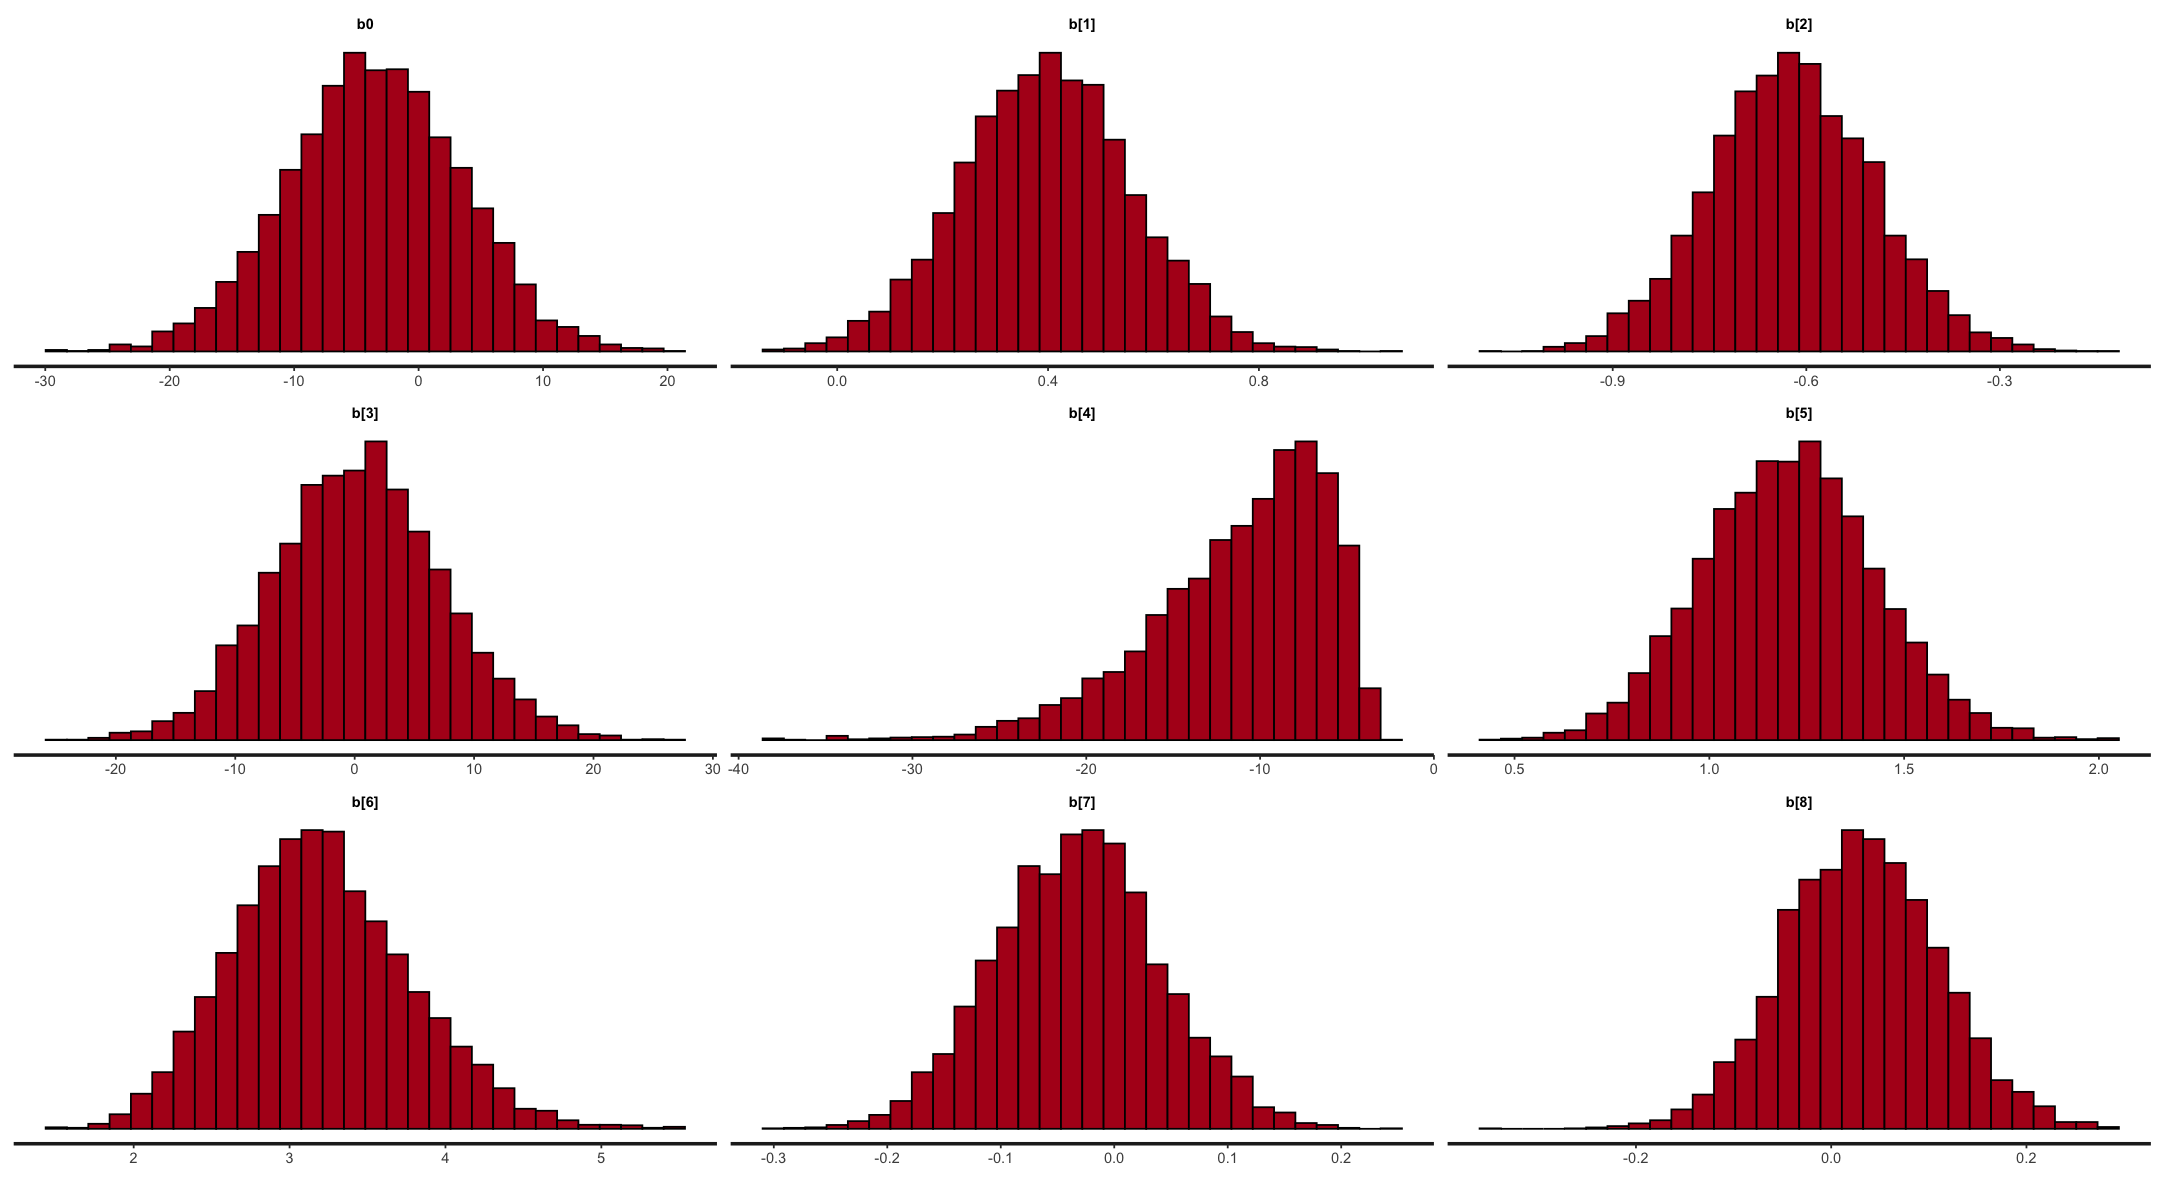

In [72]:
# Plot the obtained parameters posteriors distribution
options(repr.plot.width=18,repr.plot.height=10)
stan_hist(logit.stan, pars=c("b0","b"))

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



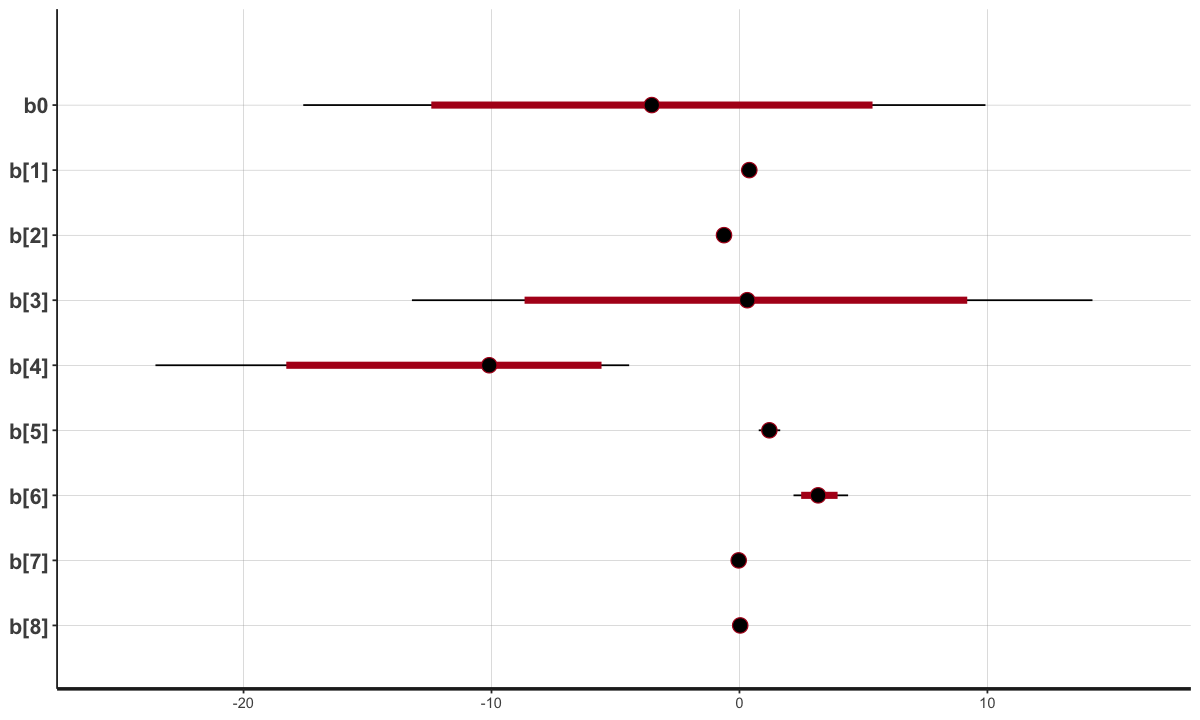

In [73]:
# Visualizing a summary of the distributions all together
# First differences are a method to summarize effects across covariates. 
# This quantity represents the difference in predicted probabilities for each 
# covariate for cases with low and high values of the respective covariate. 
# For each of these differences, all other variables are held constant at their median.
options(repr.plot.width=10, repr.plot.height=6)
stan_plot(logit.stan, pars=c("b0","b"))

In [74]:
# Print variable names to be able to interpret the results
colnames(df)

[1] "Gender"             "Age"                "Driving_License"   
[4] "Previously_Insured" "Vehicle_Age"        "Vehicle_Damage"    
[7] "Annual_Premium"     "Vintage"            "Response"

We can see that the variablest with a greater effect size on our target variable of interest `Response` are `Previusly_Insured`, with a negative effect, and `Vehicle_Damage`. This is concordantwith the results obtained with the random forest.

#### Measuring performance
 
To test performance we will use the generated quantities for the `x_test` dataset we have passed to stan. We have the posterior probability distribution for each of the testing samples we have passed to the model, which represents the pdf of the probability of each sample belonging to class 0 or class 1. To test the performance of our classifier, we will compute the MAP of each sample (i.e. the most probable probability) and use this probability to compute a classical ROC curve. If we want to compute the accuracy of the model, we need to assign samples to class 0 or class 1 using some threshold (e.g. prob < 0.5 -> class 0, else -> class 1).

From the summary, we can obtain the summary distribution of each prediction of y:

In [75]:
logit.stan.preds[1:4, ]

mean         se_mean      sd           2.5%         25%         
y_test[1] 0.6224524487 5.626427e-04 0.0473366073 5.280263e-01 5.908142e-01
y_test[2] 0.0001775855 6.261154e-06 0.0005165313 7.432008e-12 9.096060e-08
y_test[3] 0.8242091702 4.411743e-04 0.0322338666 7.543761e-01 8.036655e-01
y_test[4] 0.0000761461 2.743847e-06 0.0002233452 2.946054e-12 3.775568e-08
          50%          75%          97.5%        n_eff    Rhat     
y_test[1] 6.234578e-01 6.552382e-01 0.7109278850 7078.299 1.0003450
y_test[2] 5.336410e-06 8.860522e-05 0.0016106377 6805.884 0.9998719
y_test[3] 8.261614e-01 8.475826e-01 0.8805560734 5338.318 0.9999368
y_test[4] 2.331167e-06 3.722849e-05 0.0006919386 6625.728 0.9998452

To find the MAP for each prediction, however, we want all the values sampled from each distribution. We have one column for each sample and 6,000 values drawn from the corresponding posterior distribution:

In [76]:
logit.stan.preds <- extract(logit.stan, 'y_test')$y_test
dim(logit.stan.preds)
logit.stan.preds[1:4,1:4]

[1] 6000  300

iterations [,1]      [,2]         [,3]      [,4]        
      [1,] 0.6393961 3.714555e-04 0.8242717 2.123170e-04
      [2,] 0.5564032 9.877106e-07 0.8409432 3.006880e-07
      [3,] 0.5389399 6.391137e-07 0.7730824 3.082601e-07
      [4,] 0.6727987 1.293735e-07 0.8515609 4.371561e-08

In [77]:
MAP <- function(t){
    A<-density(t)
    return(A$x[which.max(A$y)])
}
y.MAP<-apply(logit.stan.preds,2,MAP)
str(y.MAP)

 num [1:300] 6.30e-01 -4.51e-07 8.24e-01 3.76e-06 7.30e-01 ...


Let's see the histogram of the predicted probabilities for all the testing samples, and define a threshold to assign the samples:

[1] "Accuracy with 0.4 threshold: 0.7067"


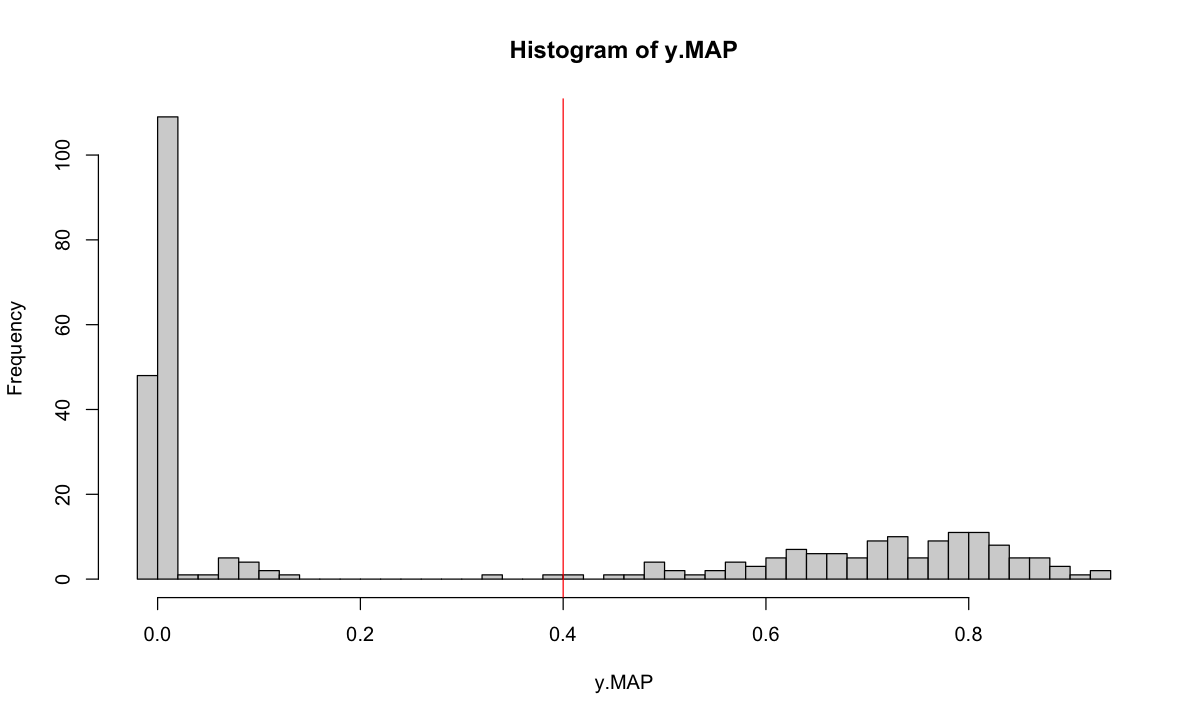

In [85]:
thres <- 0.4
hist(y.MAP, breaks=50)
abline(v=thres, col='red')

# Assign probability < 0.45 to class 0, and >= 0.45 to class 1
y_test_pred = ifelse(y.MAP < thres, 0, 1)

# Compute accuracy based on this threshold
print(paste('Accuracy with',thres,'threshold:',round(sum(y_test_pred == y_test)/length(y_test),4)))

It is however more informative to compute the AUC, for all possible decision thresholds:

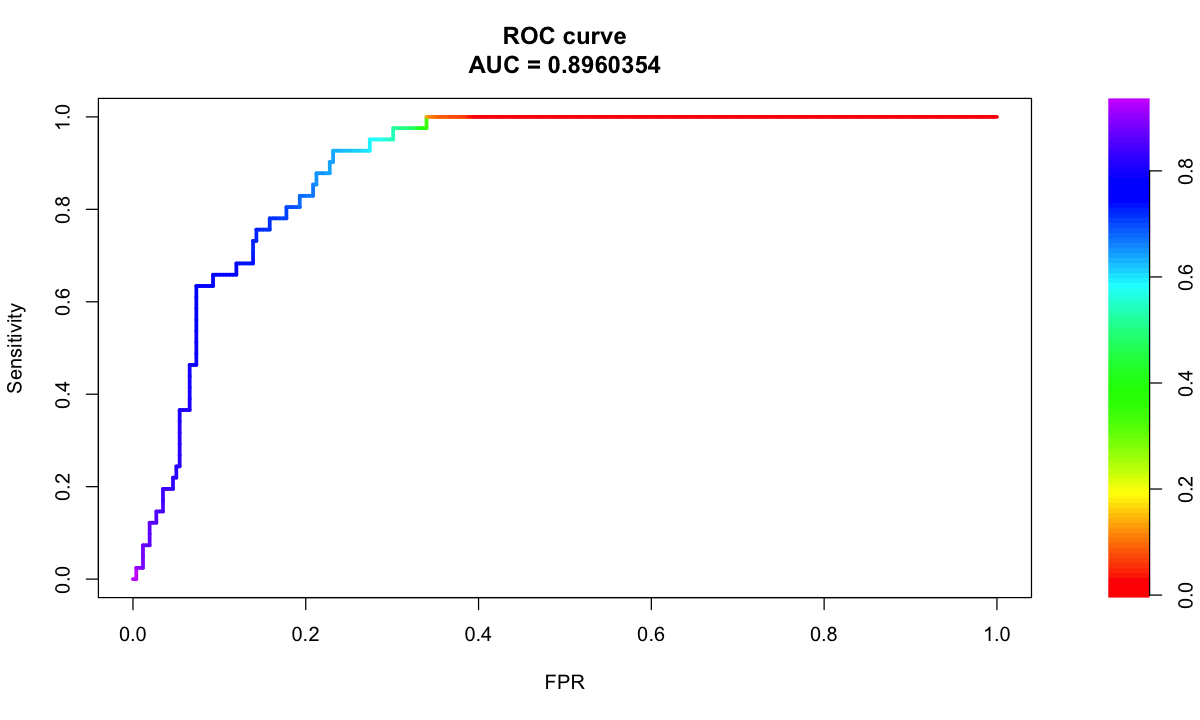

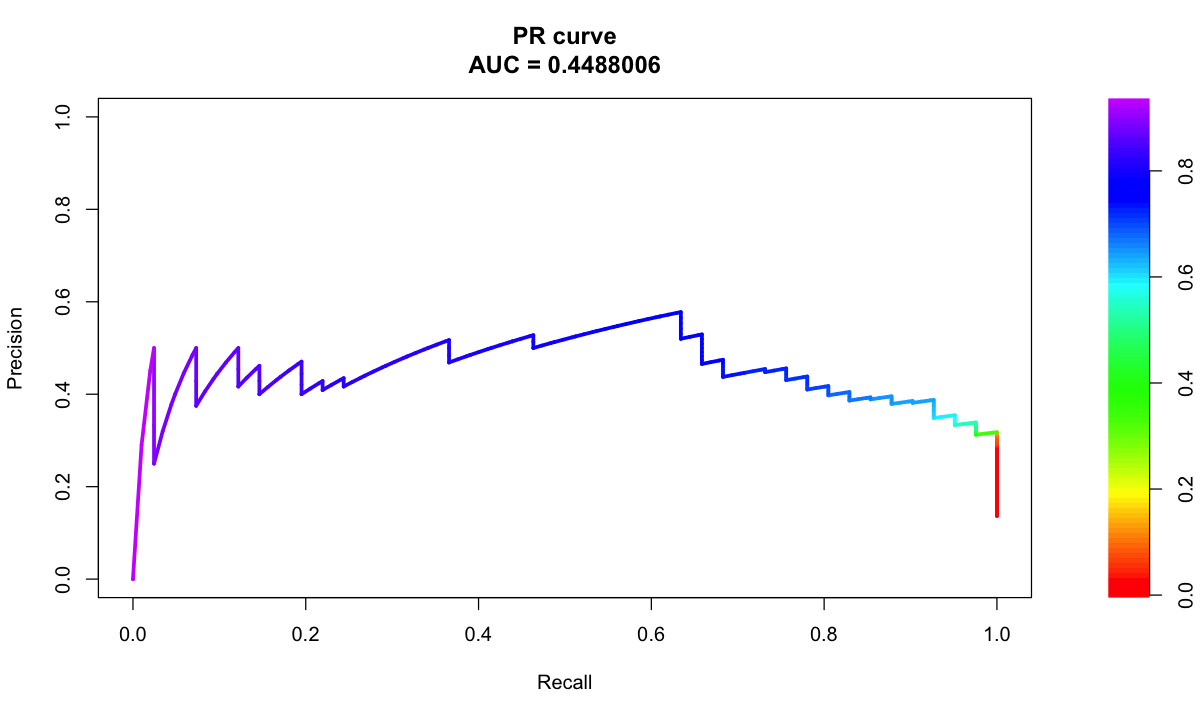

In [87]:
# Plot PROC and ROC curves based on the MAP probability of y=1
library(PRROC)

logit.stan.roc <- roc.curve(weights.class0=y_test, scores.class0=y.MAP, curve=TRUE)
plot(logit.stan.roc)

logit.stan.pr <- pr.curve(weights.class0=y_test, scores.class0=y.MAP, curve=TRUE)
plot(logit.stan.pr)

We have a similar performance as with the random forest, which is, however, only a little better than assigning all values to the majority class.

#### RStan with Bayesian Horsehoe shirnkage

Now we would like to study variable importance with another approach: using shirnkage priors that induce sparsity in the coefficients. In particular, we will try the Bayesian Horsehoe shrinkage, which is the one we have seen that is able to induce the sharpest coefficient posterior distribution. We will use the wraparound for `Stan`,  `bmrs`, which allows to easily implement this model.

In [29]:
require(brms)

Loading required package: brms

Loading required package: Rcpp

Loading 'brms' package (version 2.15.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:rstan’:

    loo


The following object is masked from ‘package:stats’:

    ar




In [30]:
logit.brms.model <- brm(Response~.,data=df,family=bernoulli, 
    prior = c(set_prior(lasso(df = 1, scale = 10),class="b")),
    chains = 3, iter = 4000, warmup = 1000, thin = 2)

Compiling Stan program...

Start sampling



In [31]:
summary(logit.brms.model)

 Family: bernoulli 
  Links: mu = logit 
Formula: Response ~ Gender + Age + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage 
   Data: df (Number of observations: 1252) 
Samples: 3 chains, each with iter = 4000; warmup = 1000; thin = 2;
         total post-warmup samples = 4500

Population-Level Effects: 
                   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept             -2.61      2.70    -8.70     2.18 1.00     3289     2387
Gender                 0.21      0.16    -0.10     0.52 1.00     4273     3984
Age                   -0.56      0.12    -0.79    -0.32 1.00     4326     3434
Driving_License        0.34      2.65    -4.39     6.40 1.00     3399     2327
Previously_Insured    -6.33      2.11   -11.90    -3.68 1.00     2089     1537
Vehicle_Age            1.42      0.21     1.02     1.82 1.00     4327     3736
Vehicle_Damage         1.99      0.38     1.27     2.79 1.00     3985     3873
Annual_Premium 

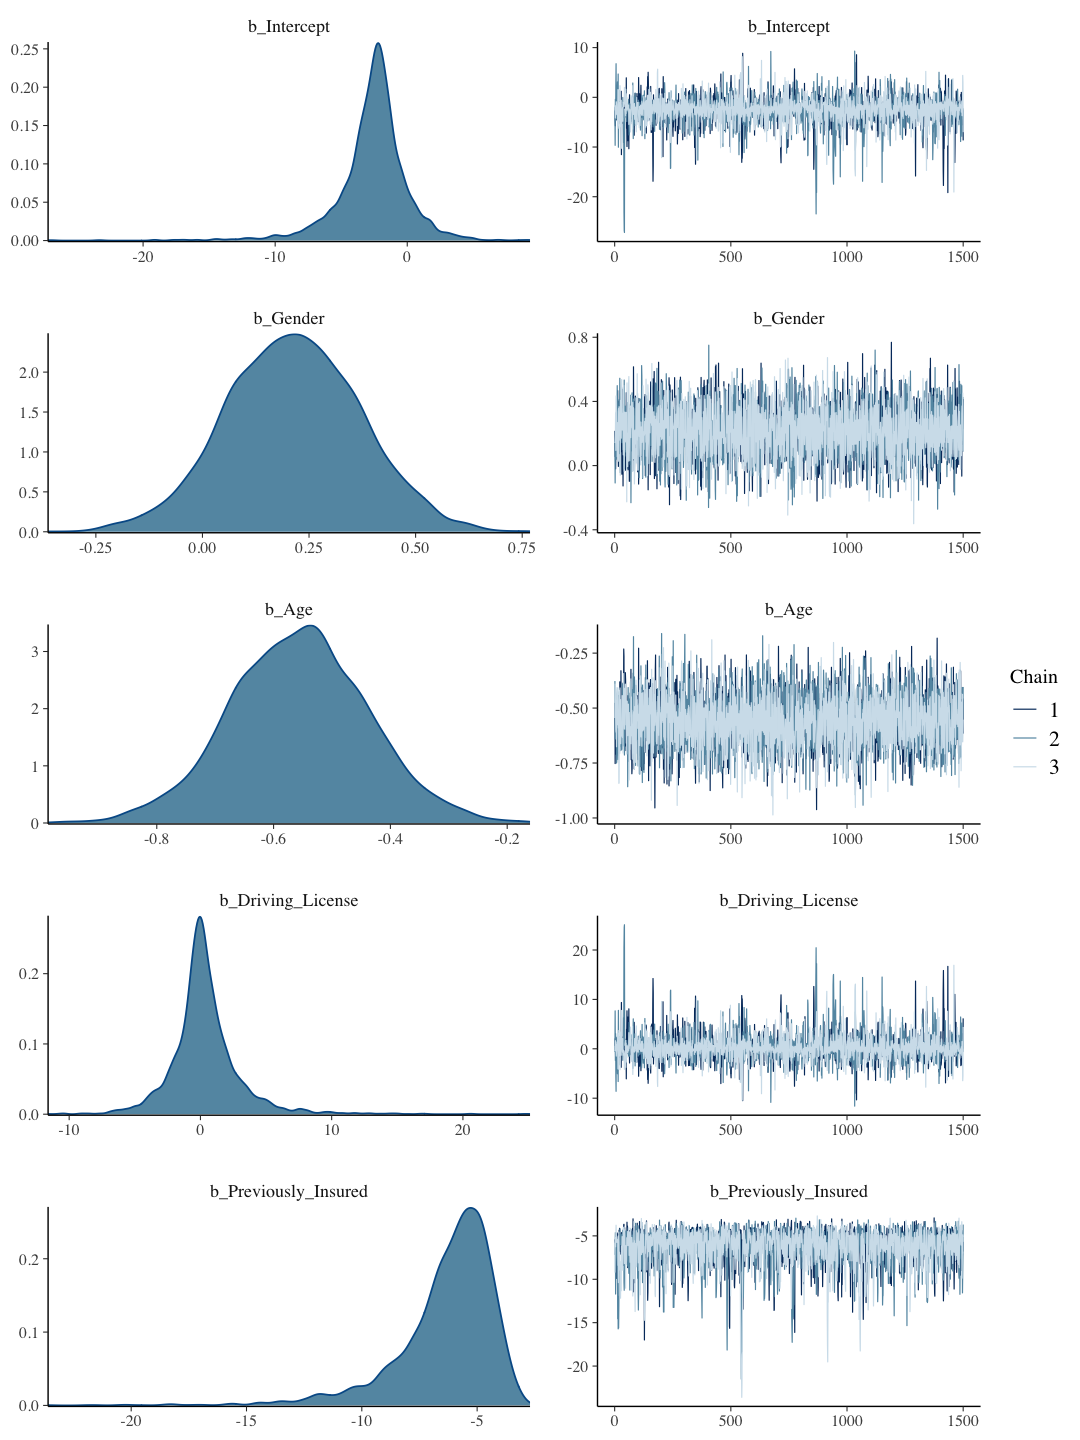

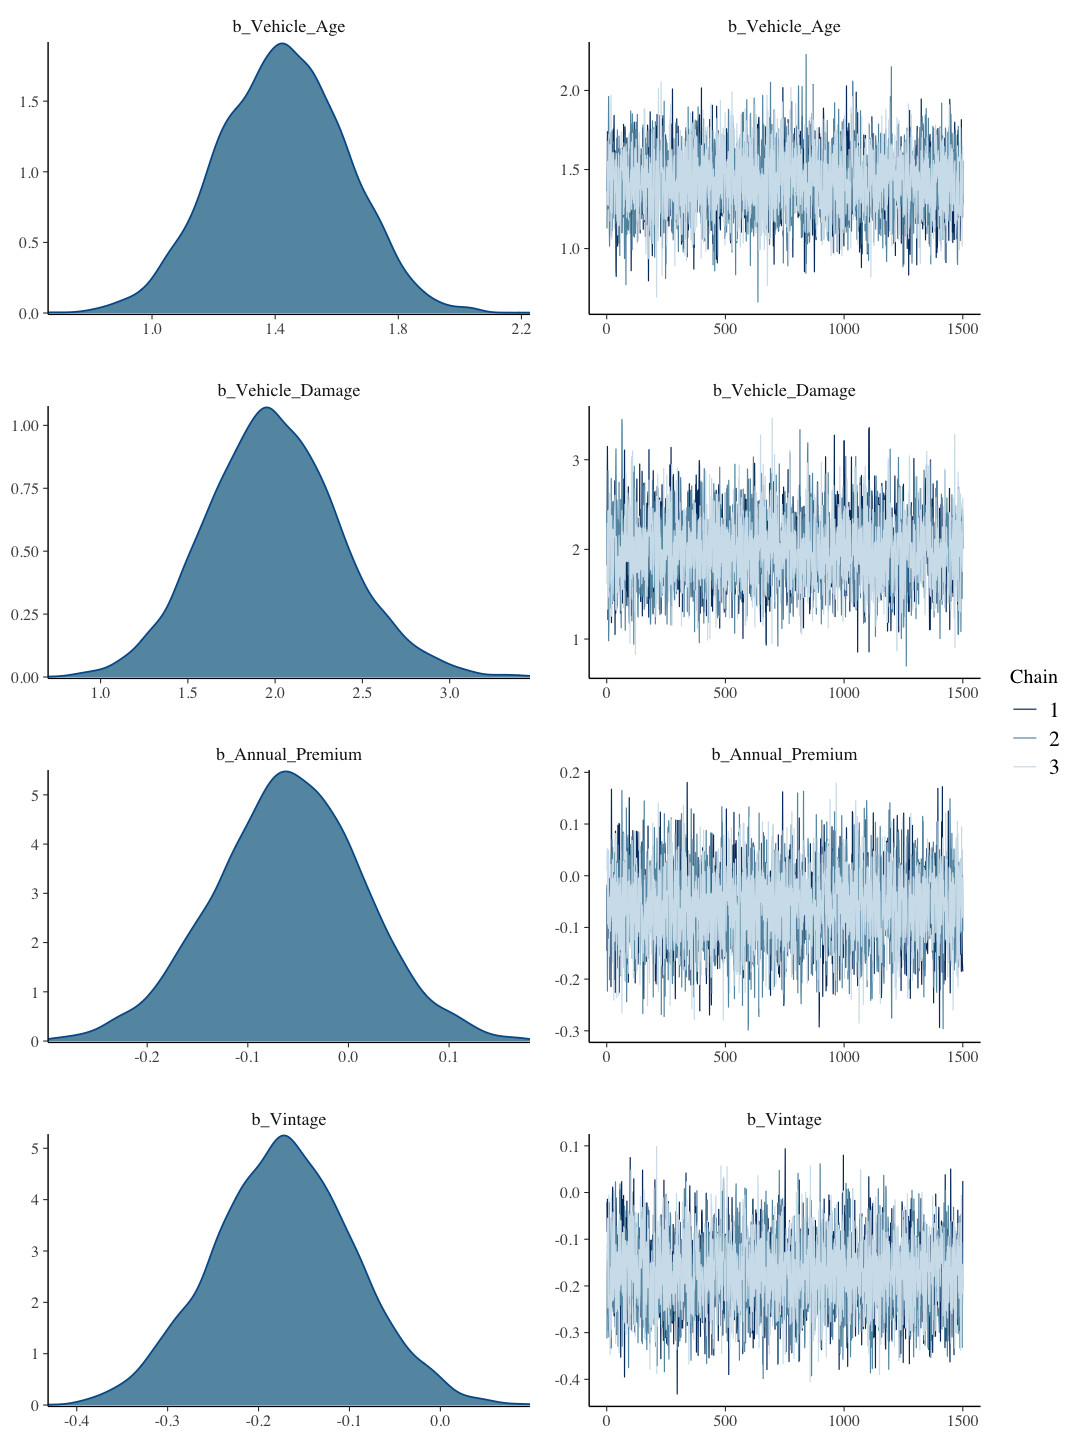

In [32]:
options(repr.plot.width=9,repr.plot.height=12)
plot(logit.brms.model)

In [33]:
logit.brms.model <- brm(Response~.,data=df,family=bernoulli, 
    prior = c(set_prior(horseshoe(df = 3, par_ratio = 0.1),class="b")),
    chains = 3, iter = 4000, warmup = 1000, thin = 2) 

Compiling Stan program...

Start sampling



In [34]:
summary(logit.brms.model)  
options(repr.plot.width=9,repr.plot.height=12)
plot(logit.brms.model)

 Family: bernoulli 
  Links: mu = logit 
Formula: Response ~ Gender + Age + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage 
   Data: df (Number of observations: 1252) 
Samples: 3 chains, each with iter = 4000; warmup = 1000; thin = 2;
         total post-warmup samples = 4500

Population-Level Effects: 
                   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept             -2.31      1.63    -6.02     0.98 1.00     4096     3475
Gender                 0.18      0.15    -0.08     0.49 1.00     3423     3679
Age                   -0.54      0.12    -0.77    -0.32 1.00     4428     4026
Driving_License        0.10      1.57    -3.08     3.76 1.00     4183     3956
Previously_Insured    -5.46      1.42    -8.99    -3.44 1.00     3071     2611
Vehicle_Age            1.41      0.21     1.00     1.82 1.00     4486     4225
Vehicle_Damage         1.96      0.38     1.22     2.75 1.00     4188     3766
Annual_Premium 

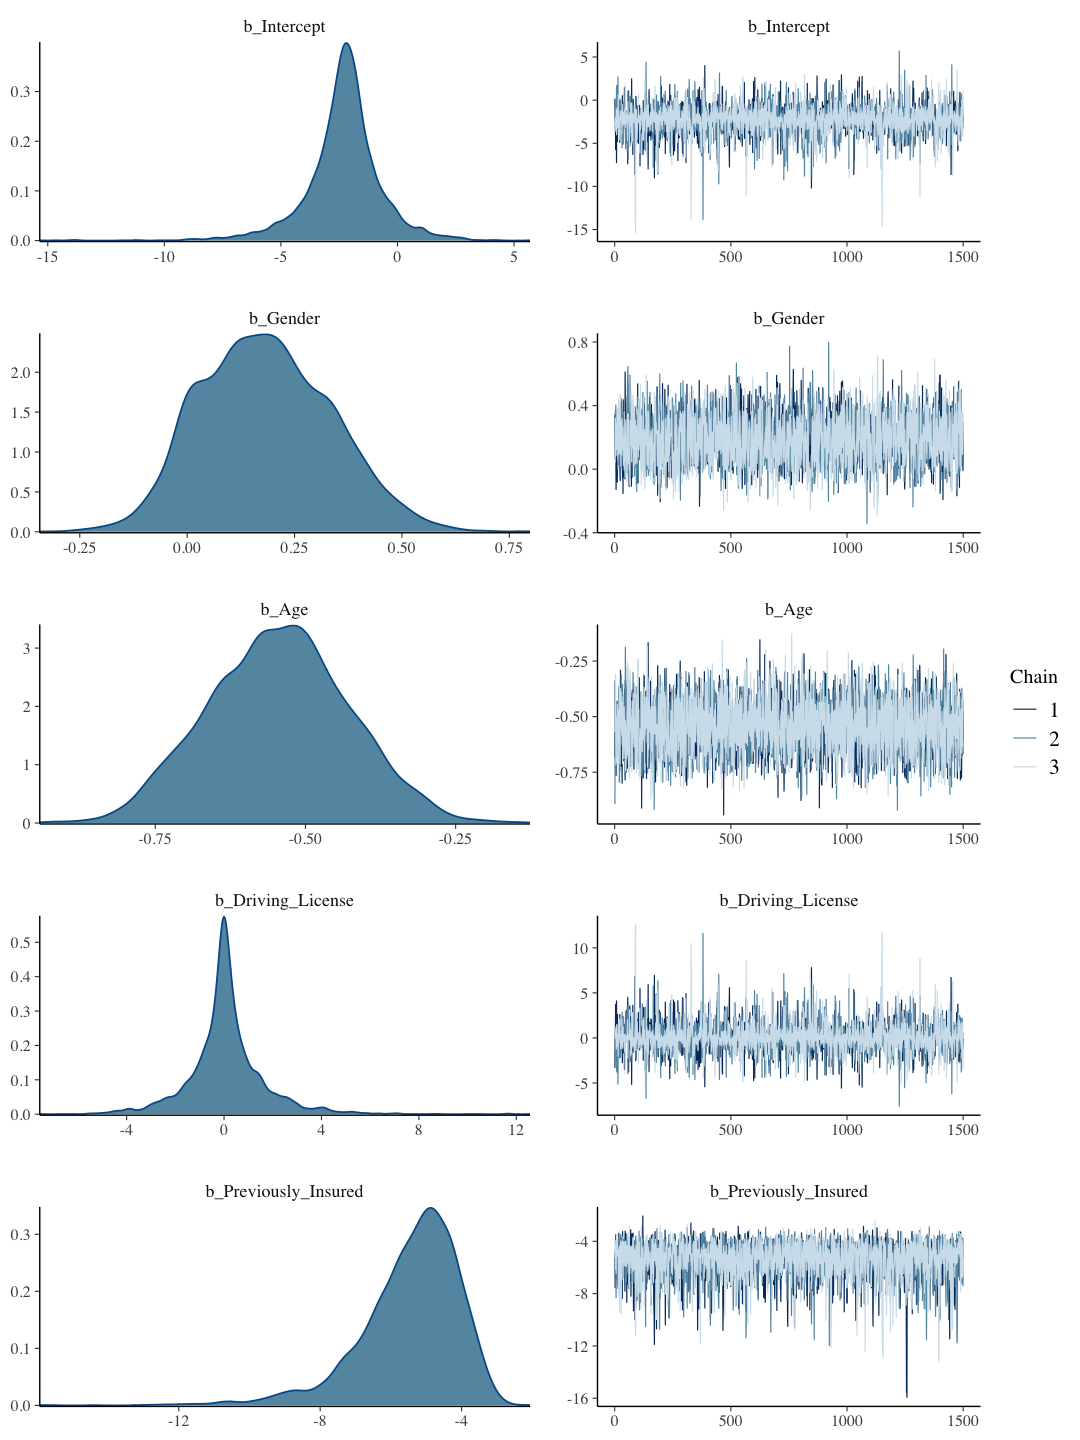

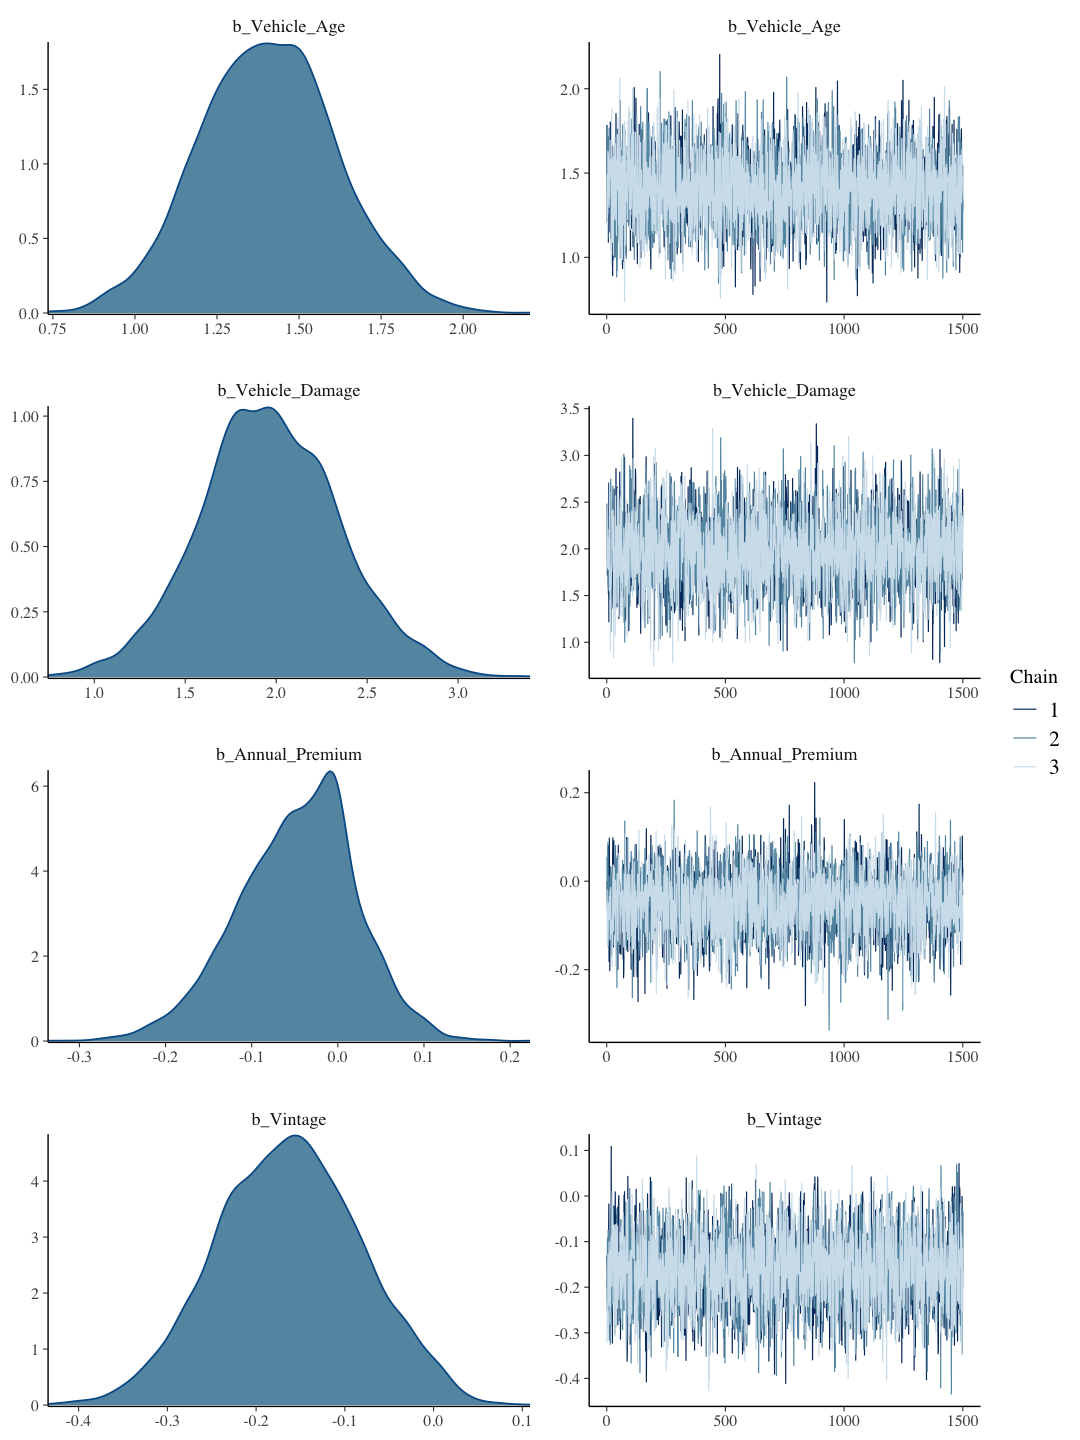

In [35]:
options(repr.plot.width=9,repr.plot.height=12)
plot(logit.brms.model)

In [ ]:
wells.glm.brms.06 <- brm(data=wells,family=bernoulli, 
formula <- paste0('Response~',paste(colnames(df)[-ncol(df)],collapse=+))
logit.brms.model <- brm(Response~.,
                        Response~Gender+Age+Driving_License+I(arsenic^2)+I(educ^2)+arsenic:educ+dist:educ,
                        data=df,family=bernoulli,
                        prior = c(set_prior(horseshoe(df = 3, par_ratio = 0.1),class="b")),
                        chains = 3, iter = 4000, warmup = 1000, thin = 2) 

In [36]:
colnames(df)

[1] "Gender"             "Age"                "Driving_License"   
[4] "Previously_Insured" "Vehicle_Age"        "Vehicle_Damage"    
[7] "Annual_Premium"     "Vintage"            "Response"

In [39]:
paste0('Response~',paste(colnames(df)[-ncol(df)],collapse='+'),'+',paste(paste0('I(',colnames(df)[-ncol(df)],'^2)'),collapse='+'))


[1] "Response~Gender+Age+Driving_License+Previously_Insured+Vehicle_Age+Vehicle_Damage+Annual_Premium+Vintage+I(Gender^2)+I(Age^2)+I(Driving_License^2)+I(Previously_Insured^2)+I(Vehicle_Age^2)+I(Vehicle_Damage^2)+I(Annual_Premium^2)+I(Vintage^2)"